In [1]:
t = 0.5

In [2]:
import numpy
import scipy.stats

In [3]:
# Market parameters

r = 0.03
def discount_factor(s):
    return numpy.exp(-r*s)

In [4]:
# Risk neutral asset parameters

kappa = 0.5
sigma = 0.2

In [5]:
# Swap

def generate_payment_dates(first_date, maturity, step):
    res = numpy.arange(first_date, maturity + step, step)
    if res[-1] > maturity:
        res = numpy.delete(res, -1)
    
    return res

t0 = 0.
tn = 5.
delta_t = 0.25

coupon_dates = generate_payment_dates(t0, tn, delta_t)

In [6]:
# Risk parameters

alpha = 0.95
delta = 5./360.

delta_prime = delta + 1./360.

In [7]:
S_t = 100.
S = {0.:100., t: S_t}

In [8]:
def cond_expectation(t, v, alpha):
    v_p_delta_prime = v + delta_prime
            
    res = alpha / discount_factor(v_p_delta_prime)
    res *= S[t] * numpy.exp(-kappa*t - 0.5*(sigma**2)*delta_prime)
    
    gauss_quantile = scipy.stats.norm.ppf(alpha)
    var = gauss_quantile
    es_div = alpha if alpha < 0.5 else 1.-alpha
    es = scipy.stats.norm.pdf(var) / es_div * numpy.sign(var)
    
    vol = sigma * numpy.sqrt(delta_prime)
    res *= numpy.exp(vol * es) - numpy.exp(vol * var)
    
    nxt_coupon_idx = numpy.searchsorted(coupon_dates, v_p_delta_prime, side='right')
    h = numpy.ediff1d(coupon_dates)
     
    sum_ = 0.
    for ii in xrange(nxt_coupon_idx, len(coupon_dates)):
        sum_ += h[ii - 1] * discount_factor(coupon_dates[ii]) * numpy.exp(kappa * coupon_dates[ii-1])
        
    return res * sum_

In [9]:
print cond_expectation(0., 1., 0.95)
print cond_expectation(0., 1., 0.05)

#raise NotImplementedError("STOP")

19.5958640298
-0.937208589063


In [10]:
time = numpy.arange(t, tn, 1./360)

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

D:\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


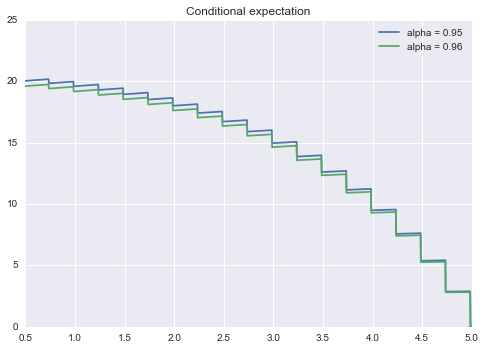

In [12]:
plt.title("Conditional expectation")
plt.plot(time, map(lambda tt: cond_expectation(0., tt, 0.95), time), label='alpha = 0.95')
plt.plot(time, map(lambda tt: cond_expectation(0., tt, 0.96), time), label='alpha = 0.96')
plt.legend(loc='best')
plt.show()

D:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


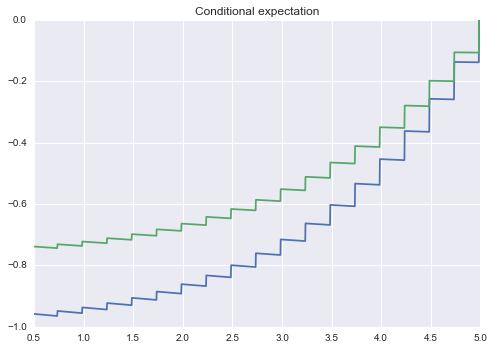

In [13]:
plt.title("Conditional expectation")

plt.legend(loc='best')
plt.plot(time, map(lambda tt: cond_expectation(0., tt, 0.05), time), label='alpha = 0.05')
plt.plot(time, map(lambda tt: cond_expectation(0., tt, 0.04), time), label='alpha = 0.04')
plt.show()

In [14]:
def ead(t, epsilon, alpha):
    one_min_alpha = 1.-alpha
    time_discr = numpy.arange(t + epsilon, numpy.minimum(t+1 + epsilon, tn) + epsilon, epsilon)
    
    sum_ = {alpha: 0., one_min_alpha: 0.}
    previous = {alpha: 0., one_min_alpha: 0.}
    for t_i in time_discr:
        for q in sum_.keys():
            current = numpy.maximum(previous[q], numpy.absolute(cond_expectation(t, t_i, q)))
            sum_[q] += current
            previous[q] = current
        
    for q in sum_.keys():
        sum_[q] *= 1.4 * epsilon
        
    return sum_

In [15]:
eps = 1./12. # the time discretization of the integral
print ead(t, eps, 0.95)

{0.95: 23.775576837121161, 0.050000000000000044: 1.137111116295628}


In [16]:
eps = 1./360. # the time discretization of the integral
print ead(t, eps, 0.95)

{0.95: 22.038237377351198, 0.050000000000000044: 1.0540196301871145}
